# ------------------------------**Sung** Work Begins Here--------------------------------

# Importing from CSV file
## = CDC.gov Dataset =

### Gather dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import os
import scipy.stats as st
from scipy.stats import linregress

### Create DataFrame for CDC Data

In [2]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df

,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
...,...,...,...,...,...,...,...,...,...
539745,2022-01,MN,SCOTT,50 to 64 years,Male,Asian,Non-Hispanic/Latino,Laboratory-confirmed case,1
539746,2020-11,MN,GOODHUE,18 to 49 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
539747,2020-11,MN,DAKOTA,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
539748,2022-01,MN,DAKOTA,50 to 64 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


## Infections by race in MN

In [3]:
# Drop NaNs and then sort by date chronologically
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['case_month', 'County', 'Race', 'Infections']]

cdc_df

,case_month,County,Race,Infections
0,2021-11,STEELE,Caucasian,1
2,2021-11,STEARNS,Caucasian,1
3,2020-05,KANDIYOHI,Caucasian,1
5,2020-04,CLAY,Caucasian,1
6,2020-10,NOBLES,Hispanic,1
...,...,...,...,...
539745,2022-01,SCOTT,Asian,1
539746,2020-11,GOODHUE,Caucasian,1
539747,2020-11,DAKOTA,Caucasian,1
539748,2022-01,DAKOTA,Caucasian,1


In [4]:
race_mn = cdc_df['Race'].unique()
race_mn = sorted(set(race_mn))
race_mn

['African American',
 'Asian',
 'Caucasian',
 'Hispanic',
 'Native American',
 'Other']

In [5]:
cdc_date = cdc_df['case_month'].unique()
cdc_date.sort()
print(cdc_date)

['2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06']


In [ ]:
# for date in cdc_date:
#     print(date)
# # you can try to append this date to the function .loc 

In [6]:
cdc_df = cdc_df.sort_values(['case_month', 'County'])
cdc_df

,case_month,County,Race,Infections
232369,2020-03,ANOKA,Caucasian,1
275945,2020-03,ANOKA,Caucasian,1
305881,2020-03,ANOKA,Caucasian,1
354490,2020-03,ANOKA,Caucasian,1
408125,2020-03,ANOKA,Caucasian,1
...,...,...,...,...
512646,2022-06,WRIGHT,Caucasian,1
528869,2022-06,WRIGHT,Caucasian,1
531029,2022-06,WRIGHT,Caucasian,1
534619,2022-06,WRIGHT,Caucasian,1


## Total

In [8]:
#total sum of infections of African American in 2021. try to have different races in columns. Tom likes this.
cdc_infections_african_american_df = cdc_df.loc[  cdc_df['Race'] == race_mn[0]]
cdc_infections_african_american_df
cdc_infections_african_american_df = cdc_infections_african_american_df.groupby(['County', 'Race'])
cdc_infections_african_american_df.head()
cdc_infections_african_american_sum_df = cdc_infections_african_american_df.sum()
cdc_infections_african_american_sum_df.head(50)

,,Infections
County,Race,
ANOKA,African American,2864
BELTRAMI,African American,3
BENTON,African American,104
BLUE EARTH,African American,213
CARLTON,African American,13
CARVER,African American,82
CHISAGO,African American,28
CLAY,African American,190
DAKOTA,African American,3433


In [9]:
cdc_infections_african_american_total = cdc_infections_african_american_sum_df['Infections'].sum()
cdc_infections_african_american_total

36467

In [10]:
#total sum of infections of asians in 2021
cdc_infections_asian_df = cdc_df.loc[  cdc_df['Race'] == race_mn[1]]
cdc_infections_asian_df
cdc_infections_asian_df = cdc_infections_asian_df.groupby(['County', 'Race'])
cdc_infections_asian_df.head()
cdc_infections_asian_sum_df = cdc_infections_asian_df.sum()
cdc_infections_asian_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Asian,1732
BLUE EARTH,Asian,30
CARVER,Asian,123
CHISAGO,Asian,14
CLAY,Asian,6
DAKOTA,Asian,1551
FREEBORN,Asian,39
HENNEPIN,Asian,7448
ISANTI,Asian,2


In [11]:
cdc_infections_asian_total = cdc_infections_asian_sum_df['Infections'].sum()
cdc_infections_asian_total

20792

In [12]:
#total sum of infections of asians in 2021
cdc_infections_caucasian_df = cdc_df.loc[  cdc_df['Race'] == race_mn[2]]
cdc_infections_caucasian_df
cdc_infections_caucasian_df = cdc_infections_caucasian_df.groupby(['County', 'Race'])
cdc_infections_caucasian_df.head()
cdc_infections_caucasian_sum_df = cdc_infections_caucasian_df.sum()
cdc_infections_caucasian_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Caucasian,24501
BECKER,Caucasian,1992
BELTRAMI,Caucasian,2216
BENTON,Caucasian,4164
BLUE EARTH,Caucasian,4555
BROWN,Caucasian,1886
CARLTON,Caucasian,1838
CARVER,Caucasian,7256
CASS,Caucasian,1502


In [13]:
cdc_infections_caucasian_total = cdc_infections_caucasian_sum_df['Infections'].sum()
cdc_infections_caucasian_total

328541

In [15]:
#total sum of infections of asians in 2021
cdc_infections_hispanic_df = cdc_df.loc[  cdc_df['Race'] == race_mn[3]]
cdc_infections_hispanic_df
cdc_infections_hispanic_df = cdc_infections_hispanic_df.groupby(['County', 'Race'])
cdc_infections_hispanic_df.head()
cdc_infections_hispanic_sum_df = cdc_infections_hispanic_df.sum()
cdc_infections_hispanic_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Hispanic,746
BENTON,Hispanic,1
BLUE EARTH,Hispanic,50
BROWN,Hispanic,46
CARVER,Hispanic,179
CHISAGO,Hispanic,10
CLAY,Hispanic,87
DAKOTA,Hispanic,1532
FREEBORN,Hispanic,141


In [16]:
cdc_infections_hispanic_total = cdc_infections_hispanic_sum_df['Infections'].sum()
cdc_infections_hispanic_total

10265

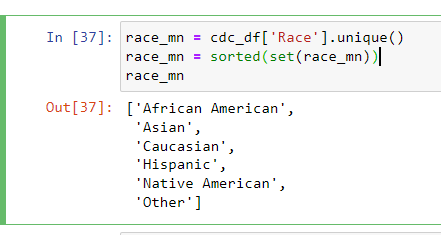

In [17]:
#total sum of infections of Native American in 2021
cdc_infections_native_american_df = cdc_df.loc[  cdc_df['Race'] == race_mn[4]]
cdc_infections_native_american_df
cdc_infections_native_american_df = cdc_infections_native_american_df.groupby(['County', 'Race'])
cdc_infections_native_american_df.head()
cdc_infections_native_american_sum_df = cdc_infections_native_american_df.sum()
cdc_infections_native_american_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Native American,73
BECKER,Native American,228
BELTRAMI,Native American,1064
CARLTON,Native American,64
CASS,Native American,195
CHISAGO,Native American,2
CLAY,Native American,29
DAKOTA,Native American,65
HENNEPIN,Native American,707


In [18]:
cdc_infections_native_american_total = cdc_infections_native_american_sum_df['Infections'].sum()
cdc_infections_native_american_total

3045

In [19]:
#total sum of infections of other in 2021
cdc_infections_other_df = cdc_df.loc[  cdc_df['Race'] == race_mn[5]]
cdc_infections_other_df
cdc_infections_other_df = cdc_infections_other_df.groupby(['County', 'Race'])
cdc_infections_other_df.head()
cdc_infections_other_sum_df = cdc_infections_other_df.sum()
cdc_infections_other_sum_df.head(50)

,,Infections
County,Race,
ANOKA,Other,348
BECKER,Other,2
BELTRAMI,Other,33
BENTON,Other,12
BLUE EARTH,Other,21
CARLTON,Other,6
CARVER,Other,49
CHISAGO,Other,5
CLAY,Other,69


In [20]:
cdc_infections_other_total = cdc_infections_other_sum_df['Infections'].sum()
cdc_infections_other_total

5499

In [21]:
#summary
total_infection_byrace_2021 = [cdc_infections_african_american_total, cdc_infections_asian_total, 
                               cdc_infections_asian_total, cdc_infections_hispanic_total, 
                               cdc_infections_native_american_total, cdc_infections_other_total]
for (race, infection) in zip(race_mn, total_infection_byrace_2021):
    print(f" {race}: {infection}")

 African American: 36467
 Asian: 20792
 Caucasian: 20792
 Hispanic: 10265
 Native American: 3045
 Other: 5499


In [42]:
#infection rate African American
african_american_infection_percent = (cdc_infections_african_american_total / sum_mn_african_american ) *100
african_american_infection_percent

#infection rate Asian
asian_infection_percent = (cdc_infections_asian_total / sum_mn_asian ) *100
asian_infection_percent

#infection rate Caucasian
caucasian_infection_percent = (cdc_infections_caucasian_total / sum_mn_caucasian ) *100
caucasian_infection_percent

hispanic_infection_percent = (cdc_infections_hispanic_total / sum_mn_hispanic ) *100
hispanic_infection_percent

native_american_infection_percent = (cdc_infections_native_american_total / sum_mn_native_american ) *100
native_american_infection_percent


other_infection_percent = (cdc_infections_other_total / sum_mn_other ) *100
other_infection_percent


percentage_race_infections = [african_american_infection_percent, asian_infection_percent, 
                              caucasian_infection_percent, hispanic_infection_percent, native_american_infection_percent, other_infection_percent]


for (race, infection_percentage) in zip(race_mn, percentage_race_infections):
    print(f" {race}: {infection_percentage}")


 African American: 10.285722344446324
 Asian: 7.613328451116807
 Caucasian: 7.428869256911829
 Hispanic: 3.3363126675875514
 Native American: 6.290152657563676
 Other: 2.8633615729482886


In [ ]:
# dataframe

race_percent_df = pd.DataFrame({'% African American':[african_american_infection_percent],
                     '% Asian':[asian_infection_percent],
                     '% Caucasian American':[caucasian_infection_percent],
                     '% Hispanic':[native_american_infection_percent],
                     '% Native American':[other_infection_percent],
                     '% Other':[cdc_hennepin_other_percent] 
                               })

race_percent_T_df = race_percent_df.T

## MN population from census data
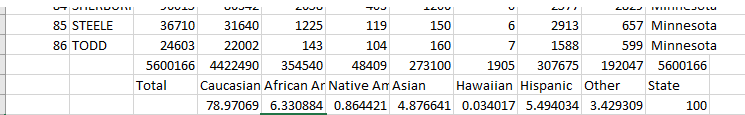

In [ ]:

# print(sum_mn_pop)
# print(sum_mn_caucasian)
# print(sum_mn_african_american)
# print(sum_mn_native_american)
# print(sum_mn_asian)
# print(sum_mn_hawaiian)
# print(percent_mn_caucasian)
# print(percent_mn_african_american)
# print(percent_mn_native_american)
# print(percent_mn_asian)
# print(percent_mn_hawaiian)
# print(percent_mn_other)

In [38]:
#population by race-Summary
cdc_byrace_df = cdc_df['Race'].value_counts()
cdc_byrace_df

Caucasian           328541
African American     36467
Asian                20792
Hispanic             10265
Other                 5499
Native American       3045
Name: Race, dtype: int64

In [ ]:
# race_percent_df = pd.DataFrame({'% African American':[cdc_hennepin_african_american_percent],
#                      '% Asian':[cdc_hennepin_asian_percent],
#                      '% Caucasian American':[cdc_hennepin_caucasian_percent],
#                      '% Hispanic':[cdc_hennepin_hispanic_percent],
#                      '% Native American':[cdc_hennepin_native_american_percent],
#                      '% Other':[cdc_hennepin_other_percent] 
#                                })

# race_percent_T_df = race_percent_df.T

In [ ]:
# how to make a dataframe that it shows that it is arranged by date but shows number of infection with caucasian in anoka county.

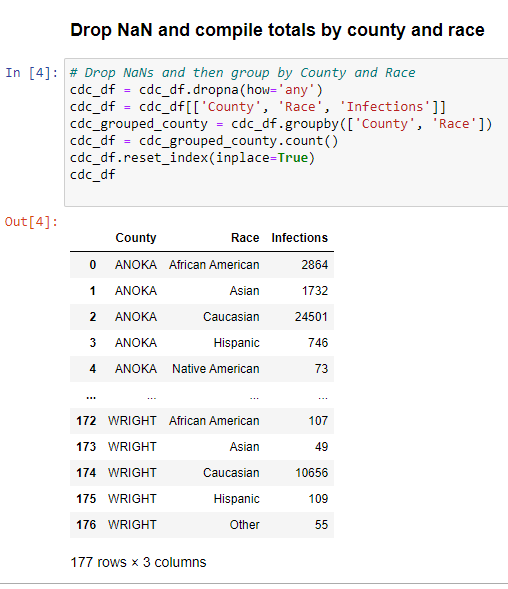

In [ ]:
#ignore

# County = []
# percent_caucasian = []
# percent_caucasian = []
# percent_caucasian = []
# percent_caucasian
# percent_caucasian

# poverty_count = []
# poverty_rate = []
# county = []
# state = []

# for row in cdc_df:
#         # Add place
#         place.append(row[0])

#         # Add population
#         population.append(row[1])

#         # Add per capita income
#         income.append(row[4])

#         # Add poverty count
#         poverty_count.append(row[8])

#         # Determine poverty rate to 2 decimal places, convert to string
#         percent = round(int(row[8]) / int(row[1]) * 100, 2)
#         poverty_rate.append(str(percent) + "%")

# for date in cdc_date:
#     cdc_2020_df = cdc_df.loc[cdc_df['case_month'] == date]
#     list.append[]
#     if date = '2021-01'
# # # you can try to append this date to the function .loc 


In [ ]:
# # Drop NaNs and then group by County and Race.
# cdc_df = cdc_df.dropna(how='any')
# cdc_df = cdc_df[['County', 'Race', 'Infections']]
# cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
# cdc_df = cdc_grouped_county.count()
# cdc_df.reset_index(inplace=True)
# cdc_df

## PLZ IGNORE BELOW  FOR NOW % of race group in Hennepin County. work on getting %race group infected by each county

In [ ]:
cdc_hennepin = cdc_df.loc[cdc_df['County'] == 'HENNEPIN']
cdc_hennepin

In [ ]:
cdc_hennepin.columns

In [ ]:
cdc_hennepin_infections = cdc_hennepin['Infections']
cdc_hennepin_infections

In [ ]:
cdc_hennepin_race = list(cdc_hennepin_infections)


# # append function
# for race in cdc_hennepin_race:
#     print(race)
    
cdc_hennepin_african_american_count = cdc_hennepin_race[0]
cdc_hennepin_asian_count = cdc_hennepin_race[1]
cdc_hennepin_caucasian_count = cdc_hennepin_race[2]
cdc_hennepin_hispanic_count = cdc_hennepin_race[3]
cdc_hennepin_native_american_count = cdc_hennepin_race[4]
cdc_hennepin_other_count = cdc_hennepin_race[5]

In [ ]:
sample_population_hennepin = cdc_hennepin['Infections'].sum()
print(f"Total sample population in Hennepin County in this randomized dataset is {sample_population_hennepin} according to the CDC.gov website")


In [ ]:
cdc_hennepin_african_american_percent = cdc_hennepin_african_american_count/sample_population_hennepin*100
cdc_hennepin_asian_percent = cdc_hennepin_asian_count/sample_population_hennepin*100
cdc_hennepin_caucasian_percent = cdc_hennepin_caucasian_count/sample_population_hennepin*100
cdc_hennepin_hispanic_percent = cdc_hennepin_hispanic_count/sample_population_hennepin*100
cdc_hennepin_native_american_percent = cdc_hennepin_native_american_count/sample_population_hennepin*100
cdc_hennepin_other_percent = cdc_hennepin_other_count/sample_population_hennepin*100

In [ ]:
race_percent_df = pd.DataFrame({'% African American':[cdc_hennepin_african_american_percent],
                     '% Asian':[cdc_hennepin_asian_percent],
                     '% Caucasian American':[cdc_hennepin_caucasian_percent],
                     '% Hispanic':[cdc_hennepin_hispanic_percent],
                     '% Native American':[cdc_hennepin_native_american_percent],
                     '% Other':[cdc_hennepin_other_percent] 
                               })

race_percent_T_df = race_percent_df.T

In [ ]:
# Rename columns.  please review the class activity

race_percent_T_df.columns = ["% race proportion infected with COVID-19 in Hennepin County from the reduced CDC dataset"]
race_percent_T_df

In [ ]:
# Create a boxplot to compare means. look at hw
race_percent_T_df.boxplot("% race proportion infected with COVID-19 in Hennepin County from the reduced CDC dataset", by = race_percent_T_df.iloc[:, 0], figsize=(20, 10))

In [ ]:
# Extract individual groups should i append a column?
group0 = race_percent_T_df[race_percent_T_df["num_workouts"] == 0]["resting_heart_rate"]
group1 = df[df["num_workouts"] == 1]["resting_heart_rate"]
group2 = df[df["num_workouts"] == 2]["resting_heart_rate"]
group3 = df[df["num_workouts"] == 3]["resting_heart_rate"]
group4 = df[df["num_workouts"] == 4]["resting_heart_rate"]

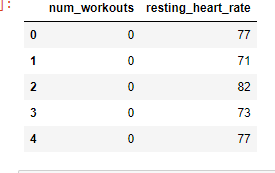

In [ ]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df


# Pulling data using API with the help of JSON
## = Census Dataset =

### Drop NaN and compile totals by county and race

### Create poverty DataFrame based on US Census

In [23]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

In [24]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)

# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df



,County,State,Poverty Total,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,Minnesota,1373,717,29,97,8,0,245,277,2020
83,ROSEAU,Minnesota,1133,971,6,67,11,0,28,50,2020
84,SHERBURNE,Minnesota,4953,2857,578,171,251,0,737,359,2020
85,STEELE,Minnesota,2887,1835,426,113,3,0,149,361,2020


In [25]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,11778,3697,327,953,0,1964,1551
1,BECKER,2296,17,709,45,0,381,140
2,BELTRAMI,3657,310,3056,39,0,734,371
3,BENTON,2605,333,19,73,0,205,122
4,BIG STONE,596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
82,RENVILLE,717,29,97,8,0,245,277
83,ROSEAU,971,6,67,11,0,28,50
84,SHERBURNE,2857,578,171,251,0,737,359
85,STEELE,1835,426,113,3,0,149,361


In [26]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df

,County,Race,Poverty
0,AITKIN,African American,13
1,AITKIN,Asian,0
2,AITKIN,Caucasian,1711
3,AITKIN,Hawaiian,0
4,AITKIN,Hispanic,45
...,...,...,...
604,YELLOW MEDICINE,Caucasian,722
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,53
607,YELLOW MEDICINE,Native American,30


### Function for quickly calling a DataFrame

### Create population DataFrame by county and race

In [27]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic',
#     'B03002_005E': 'American Indian and Alaska Native alone'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df

,County,Population Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080
1,BECKER,34227,29290,146,1938,209,6,738,1900
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514
3,BENTON,40476,35979,1876,49,378,0,1086,1108
4,BIG STONE,4974,4787,3,3,0,0,102,79
...,...,...,...,...,...,...,...,...,...
82,RENVILLE,14572,12741,67,186,108,0,1268,202
83,ROSEAU,15259,13876,124,254,399,0,223,383
84,SHERBURNE,96015,86342,2658,403,1206,0,2577,2829
85,STEELE,36710,31640,1225,119,150,6,2913,657


In [ ]:
# # Edited merge_df for nan infections to be 0
# merged_df = pd.merge(mn_pop_df, poverty_df, on=['County', 'Race'])
# merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
# merged_df["Infections"] = merged_df["Infections"].fillna(0)
# merged_df

# # Convert all numerical values in merged_df from strings to int
# merged_df["Population"] = merged_df["Population"].astype(int)
# merged_df["Poverty"] = merged_df["Poverty"].astype(int)
# merged_df["Infections"] = merged_df["Infections"].astype(int)

# # Calculate poverty and infection rates
# poverty_rate = []
# infection_rate = []

# i = 0
# while i < len(merged_df):
#     if merged_df["Population"][i] == 0:
#         poverty_rate.append(0)
#         infection_rate.append(0)
#     else: 
#         poverty_rate.append(merged_df["Poverty"][i] / merged_df["Population"][i])
#         infection_rate.append(merged_df["Infections"][i] / merged_df["Population"][i])
#     i += 1
    
# merged_df["Poverty Rate"] = poverty_rate
# merged_df["Infection Rate"] = infection_rate

# merged_df[merged_df["County"] == "CROW WING"]

In [28]:
mn_pop_df.columns

Index(['County', 'Population Total', 'Caucasian', 'African American',
       'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other'],
      dtype='object')

In [ ]:
# please obtain total population by race for all counties (MN)-08072022 COMMENT

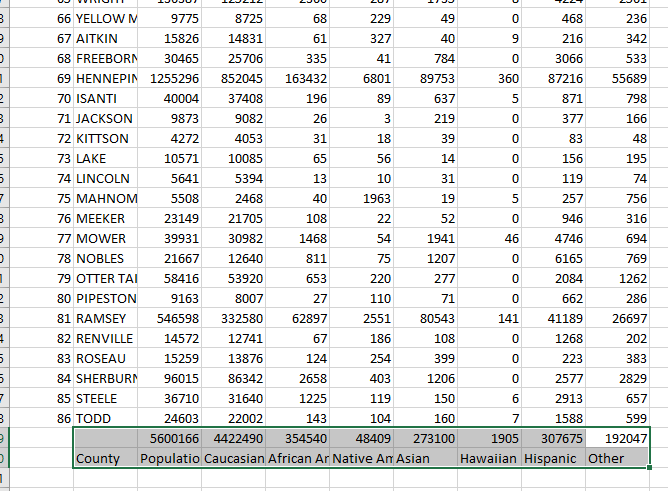

In [35]:
#population by race infected with covid-19

mn_pop = mn_pop_df['Population Total']
mn_caucasian_pop = mn_pop_df['Caucasian']
mn_african_american_pop = mn_pop_df['African American']
mn_native_american_pop = mn_pop_df['Native American']
mn_asian_pop = mn_pop_df['Asian']
mn_hawaiian_pop = mn_pop_df['Hawaiian']
mn_hispanic_pop = mn_pop_df['Hispanic']
mn_other_pop = mn_pop_df['Other']


# caucasian_sum = mn_pop_df['Caucasian'].sum()
# caucasian_sum

# mn_pop_df.loc[  mn_pop_df['County'] == 'HENNEPIN'  ]

# mn_pop_df = mn_pop_df['Race'].value_counts()
# cdc_byrace_df

In [36]:
mn_pop_list = list(mn_pop)
mn_pop_list
mn_caucasian_list = list(mn_caucasian_pop)
mn_caucasian_list
mn_african_american_list = list(mn_african_american_pop)
mn_african_american_list
mn_native_american_list = list(mn_native_american_pop)
mn_native_american_list
mn_asian_list = list(mn_asian_pop)
mn_asian_list
mn_hawaiian_list = list(mn_hawaiian_pop)
mn_hawaiian_list
mn_hispanic_list = list(mn_hispanic_pop)
mn_hispanic_list
mn_other_list = list(mn_other_pop)
mn_other_list
print(type(mn_pop_list[0]))

<class 'str'>


In [37]:

# print([int(x) for x in mn_pop_list])
mn_pop_int_list = [int(x) for x in mn_pop_list]
mn_caucasian_int_list = [int(x) for x in mn_caucasian_list]
mn_african_american_int_list = [int(x) for x in mn_african_american_list]
mn_native_american_int_list = [int(x) for x in mn_native_american_list]
mn_asian_int_list = [int(x) for x in mn_asian_list]
mn_hawaiian_int_list = [int(x) for x in mn_hawaiian_list]
mn_hispanic_int_list = [int(x) for x in mn_hispanic_list]
mn_other_int_list = [int(x) for x in mn_other_list]


print(type(mn_pop_int_list[0]))

<class 'int'>


In [39]:
sum_mn_pop = sum(mn_pop_int_list)
sum_mn_caucasian = sum(mn_caucasian_int_list)
sum_mn_african_american = sum(mn_african_american_int_list)
sum_mn_native_american = sum(mn_native_american_int_list)
sum_mn_asian = sum(mn_asian_int_list)
sum_mn_hawaiian = sum(mn_hawaiian_int_list)
sum_mn_hispanic = sum(mn_hispanic_int_list)
sum_mn_other = sum(mn_other_int_list)

print(sum_mn_pop)
print(sum_mn_caucasian)
print(sum_mn_african_american)
print(sum_mn_native_american)
print(sum_mn_asian)
print(sum_mn_hawaiian)
print(sum_mn_hispanic)
print(sum_mn_other)

5600166
4422490
354540
48409
273100
1905
307675
192047


In [40]:
percent_mn_caucasian = sum_mn_caucasian/sum_mn_pop*100
percent_mn_african_american = sum_mn_african_american/sum_mn_pop*100
percent_mn_native_american = sum_mn_native_american/sum_mn_pop*100
percent_mn_asian = sum_mn_asian/sum_mn_pop*100
percent_mn_hawaiian = sum_mn_hawaiian/sum_mn_pop*100
percent_mn_hispanic = sum_mn_hispanic/sum_mn_pop*100
percent_mn_other = sum_mn_other/sum_mn_pop*100

print(percent_mn_caucasian)
print(percent_mn_african_american)
print(percent_mn_native_american)
print(percent_mn_asian)
print(percent_mn_hawaiian)
print(percent_mn_hispanic)
print(percent_mn_other)

78.97069479726136
6.330883763088452
0.8644208046690045
4.876641156708569
0.03401684878626812
5.494033569719183
3.429309059767157


In [ ]:
#Population in Hennepin County by race


mn_pop_hennepin_df = mn_pop_df.loc[  mn_pop_df['County'] == 'HENNEPIN'  ]
mn_pop_hennepin_df

In [ ]:
mn_pop_hennepin_asian_count = mn_pop_hennepin_df['Asian']
mn_pop_hennepin_asian_count(index = False)
print(mn_pop_hennepin_asian_count)
# mn_pop_hennepin_asian_count = mn_pop_hennepin_asian_count.astype(str).astype(int)


# mn_pop_hennepin_asian_count.reset_index()

mn_pop_hennepin_asian_count = pd.DataFrame(mn_pop_hennepin_asian_count)
# mn_pop_hennepin_asian_count
# mn_pop_census_hennepin_asian_per_df = 

In [ ]:
mn_pop_hennepin_total_population = mn_pop_hennepin_df['Population Total']
mn_pop_hennepin_total_population = mn_pop_hennepin_total_population.astype(str).astype(int)
mn_pop_hennepin_total_population

In [ ]:
mn_pop_census_hennepin_asian_per = mn_pop_hennepin_asian_count/mn_pop_hennepin_total_population*100
mn_pop_census_hennepin_asian_per = round(mn_pop_census_hennepin_asian_per, 2) 
mn_pop_census_hennepin_asian_per

In [ ]:
#Population in Anoka County by race
mn_pop_anoka_df = mn_pop_df.loc[  mn_pop_df['County'] == 'ANOKA'  ]
mn_pop_anoka_df

In [ ]:
mn_pop_anoka_asian_count = mn_pop_anoka_df['Asian']
mn_pop_anoka_asian_count = mn_pop_anoka_asian_count.astype(str).astype(int)
mn_pop_anoka_asian_count
# mn_pop_census_hennepin_asian_per_df = 

In [ ]:
mn_pop_anoka_total_population = mn_pop_anoka_df['Population Total']
mn_pop_anoka_total_population = mn_pop_anoka_total_population.astype(str).astype(int)
mn_pop_anoka_total_population

In [ ]:
mn_pop_census_anoka_asian_per = mn_pop_anoka_asian_count/mn_pop_anoka_total_population*100
mn_pop_census_anoka_asian_per = round(mn_pop_census_anoka_asian_per, 2) 
mn_pop_census_anoka_asian_per

In [ ]:
#Population in Ramsey County by race
mn_pop_ramsey_df = mn_pop_df.loc[  mn_pop_df['County'] == 'RAMSEY'  ]
mn_pop_ramsey_df

In [ ]:
mn_pop_ramsey_asian_count = mn_pop_ramsey_df['Asian']
mn_pop_ramsey_asian_count = mn_pop_ramsey_asian_count.astype(str).astype(int)
mn_pop_ramsey_asian_count
# mn_pop_census_hennepin_asian_per_df = 

In [ ]:
mn_pop_ramsey_total_population = mn_pop_ramsey_df['Population Total']
mn_pop_ramsey_total_population = mn_pop_ramsey_total_population.astype(str).astype(int)
mn_pop_ramsey_total_population

In [ ]:
mn_pop_census_ramsey_asian_per = mn_pop_ramsey_asian_count/mn_pop_ramsey_total_population*100
mn_pop_census_ramsey_asian_per = round(mn_pop_census_ramsey_asian_per, 2) 
mn_pop_census_ramsey_asian_per

### Coordinates for heat map -- if time permits

In [ ]:
# Get the coordinates of counties in MN
url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

table = pd.read_html(url)
df = table[0]
Counties = df.loc[df['State'] == "MN", : ]
counties_df = Counties[['County [2]', 'Latitude', 'Longitude']]
counties_df#.to_csv("../Project_1/county_geo.csv")  

In [ ]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df


In [ ]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df

### Merge the datasets

In [ ]:
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'])
merged_df

## Practice codes

In [ ]:
#old
url = "https://api.census.gov/data/2019/acs/acs5?get=NAME,B19013_001E,B01003_001E,B01002_001E,B19301_001E,B17001_002E,B23025_005E,B02001_001E,B02001_002E,B02001_003E,B02001_005E,B02001_006E,B02001_007E,B02001_004E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)

census_df = json_to_dataframe(response)
# Split NAME into county & state
name = census_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = census_df['County']=name[0]
STATE = census_df['State']=name[1]
census_df.drop(columns=["NAME"], inplace=True)

# Rename columns to something intelligible
census_df = census_df[['County', 'State', 'B19013_001E', 'B01003_001E', 'B01002_001E', 'B19301_001E', 
                       'B17001_002E', 'B23025_005E', 'B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 'B02001_004E']]
census_df = census_df.rename(columns={
    'B01003_001E':'Population',
    'B01002_001E': 'Median Age',
    'B19013_001E': 'Median Household Income',
    'B19301_001E': 'Per Capita Income',
    'B17001_002E': 'Poverty Count',
    'B23025_005E': 'Unemployment Count',
    'B02001_001E': 'Race',
    'B02001_002E': 'Caucasian/White',
    'B02001_003E': 'African American',
    'B02001_005E': 'Asian',
    'B02001_006E': 'Native Hawaiian and Other Pacific Islander alone',
    'B02001_004E': 'American Indian and Alaska Native',
    'B02001_007E': 'Some other Race'
})

# Remove ...County from County in dataframe in each row
census_df['County'] = census_df['County'].replace('County', '', regex=True)

census_df

In [ ]:
# create data
# df = pd.DataFrame({'Column 1':[rounded_Asian_in_hennepin,rounded_Asian_in_anoka,rounded_Asian_in_ramsey],
                     
#                    'Column 2':[7.15, 4.55, 14.74]})
# df

In [ ]:
# total = 0
 
# # creating a list
 
# # Iterate each element in list
# # and add them in variable total
# for element in range(0, len(mn_pop_list)):
#     total = total + mn_pop_list[element]

In [ ]:
df= pd.DataFrame({'number': np.random.randint(1, 100, 10)})
df['bins'] = pd.cut(x=df['number'], bins=[1, 20, 40, 60,
                                          80, 100])
print(df)
 
# We can check the frequency of each bin
print(df['bins'].unique())

In [ ]:
import pandas as pd
import numpy as np
 
df = pd.DataFrame({'number': np.random.randint(1, 100, 10)})
df['bins'] = pd.cut(x=df['number'], bins=[1, 20, 40, 60, 80, 100],
                    labels=['1 to 20', '21 to 40', '41 to 60',
                            '61 to 80', '81 to 100'])
 
print(df)
 
# We can check the frequency of each bin
print(df['bins'].unique())

# -------------------------------------**Sung** Work Ends Here-----------------------------------